In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('full_zno.csv')

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_48461/2343335949.py:1: DtypeWarning: Columns (17,20,23,26,29,32,35,38,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_zno.csv')


1. Анализ по отдельным переменным
   1.1 Годы
   1.2 Профиль участника
   1.3 География
   1.4 Предметы
2. Комбинированный анализ
   2.1 Профиль + Годы
   2.2 География + Годы
   2.3 Предметы + Годы
   2.4 Профиль + Предметы
4. Общие выводы и ключевые инсайты
5. Визуализации и дашборды

# Аналіз по окремих змінних | Analysis by individual variables | Анализ по отдельным переменным

## 1.1 Роки | Years | Годы

Шаблон анализа:
Количество участников по годам
- participants_by_year, 
- participants_by_year_plot

Процент неявок по годам
- noshow_by_year

Средний / медианный балл по годам 
- by_year, 
- mean_median_by_year_plot

Стандартное отклонение 
- by_year

% высокобалльников / низкобалльников
- high_low_failed_by_year

Top–5 / Bottom–5 лет по среднему баллу
Динамика по годам: рост / падение количества участников, среднего балла, процента неявок +

### Кількість учасників за роками та частка кожного року у загальному масиві | Number of participants by year and share of each year in the total dataset | Количество участников по годам и доля каждого года в общем массиве

In [3]:
participants_count = df.groupby('Year')['Id'].count().sort_index()

In [4]:
participants_percent = (df['Year'].value_counts(normalize=True).sort_index() * 100).round(2)

In [5]:
participants_by_year = pd.concat([participants_count, participants_percent], axis=1) \
                        .reset_index().rename(columns={'Id':'count',
                                                       'proportion': '%_of_total'})

In [6]:
participants_by_year

,Year,count,%_of_total
0,2016,268003,8.59
1,2017,240889,7.72
2,2018,335687,10.76
3,2019,353813,11.34
4,2020,379299,12.16
5,2021,389323,12.48
6,2022,234104,7.50
7,2023,288935,9.26
8,2024,312508,10.02
9,2025,317091,10.16


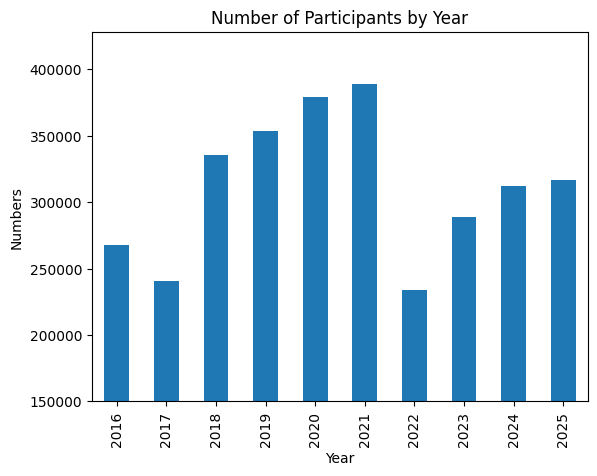

In [7]:
fig, ax1 = plt.subplots()

participants_count.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Numbers')
ax1.set_ylim(150000, participants_count.max() * 1.1)
ax1.set_title('Number of Participants by Year')

participants_by_year_plot = fig

Укр:
Чітко простежується зростання кількості учасників з 2016 по 2021 рік. Різке зниження у 2022 році пояснюється початком повномасштабної війни. З 2023 року спостерігається поступове відновлення активності. Порівняння 2024 і 2025 років показує практично однакову кількість учасників. Особливо цікаво буде побачити дані за 2026 рік, щоб оцінити подальший тренд з урахуванням поточної ситуації в країні

Рус:
Чётко прослеживается рост числа участников с 2016 по 2021 год. Резкое снижение в 2022 году объясняется началом полномасштабной войны. С 2023 года наблюдается постепенное восстановление активности. Сравнение 2024 и 2025 годов показывает практически одинаковое количество участников. Особенно интересно будет увидеть данные за 2026 год, чтобы оценить дальнейший тренд с учётом текущей ситуации в стране.

Eng:
There is a clear increase in the number of participants from 2016 to 2021. The sharp decline in 2022 is explained by the start of the full-scale war. Since 2023, a gradual recovery in activity has been observed. A comparison of 2024 and 2025 shows almost the same number of participants. It will be especially interesting to see the data for 2026 to assess the future trend given the current situation in the country.

### Відсоток неявок за роками | Percentage of no-shows by year | Процент неявок по годам

In [8]:
prefs = ('Ukr', 'Math', 'Hist', 'Eng', 'Fra', 'Deu', 'Spa', 'Phys', 'Chem', 'Bio', 'Geo', 'UkrLit')

In [9]:
df['statuses_comb'] = df[[pref + 'Status' for pref in prefs]] \
        .apply(lambda x: set(x) - {'Не складав'}, axis=1)

збираю статуси по всіх предметах в одну множину, щоб визначити відсоток учасників
за комбінацією статусів.

In [10]:
statuses_comb = df['statuses_comb'].value_counts().reset_index()

In [11]:
statuses_comb['statuses_comb'] = statuses_comb['statuses_comb'].apply(lambda x: ', '.join(x))

In [12]:
statuses_comb.iloc[7, 0] = 'Не складав'

In [13]:
statuses_comb['%_of_total'] = (statuses_comb['count'] / len(df) * 100).round(2)

Логіка така:

Зараховано — учасник подолав поріг з усіх предметів, у яких брав участь.
Не зараховано — учасник не подолав поріг ні з одного предмета.

Зараховано, Не зараховано — мінімум 1 предмет склав і мінімум 1 предмет не склав.

Не з’явився або анульовано — учасник не з’явився на жоден зареєстрований тест.

Зараховано, Не з’явився або анульовано — мінімум 1 предмет склав, мінімум на 1 предмет не з’явився.

Не зараховано, Не з’явився або анульовано — мінімум 1 предмет не склав, мінімум на 1 предмет не з’явився.

Зараховано, Не зараховано, Не з’явився або анульовано — мінімум 1 склав, мінімум 1 не склав, мінімум 1 не з’явився.

Не складав — невелика кількість учасників, які не складали. 

Але чому тоді вони є в ДФ? 
Усе тому, що насправді ці учасники складали тести, але відмовилися переводити бали в систему 100–200.
Тому для них статус «Не складав».


In [14]:
statuses_comb #за все года

,statuses_comb,count,%_of_total
0,Зараховано,2086792,66.89
1,"Зараховано, Не зараховано",460583,14.76
2,Не з'явився або анульовано,316739,10.15
3,"Не з'явився або анульовано, Зараховано",122769,3.94
4,Не зараховано,85555,2.74
5,"Не з'явився або анульовано, Зараховано, Не зар...",34212,1.10
6,"Не з'явився або анульовано, Не зараховано",10591,0.34
7,Не складав,2411,0.08


In [15]:
df['statuses_comb'] = df['statuses_comb'].apply(lambda x: ', '.join(x))

In [16]:
no_show_by_year = df[df['statuses_comb'] == "Не з'явився або анульовано"].groupby('Year')['Id'].count().reset_index()

In [17]:
total_by_year = df['Year'].value_counts().reset_index()

In [18]:
no_show_by_year_and_total = no_show_by_year.merge(total_by_year, on='Year').rename(columns={'Id':'no_show', 'count':'total_count'})

In [19]:
no_show_by_year_and_total['%no_show_of_total'] = no_show_by_year_and_total['no_show'] / no_show_by_year_and_total['total_count'] * 100

In [20]:
no_show_by_year_and_total['%no_show_of_total'] = no_show_by_year_and_total['%no_show_of_total'].round(1)

In [21]:
total_tests = df[[pref + 'Status' for pref in prefs] + ['Year']]

In [22]:
total_tests["Не з'явився"] = (total_tests[[pref + 'Status' for pref in prefs]] == "Не з'явився або анульовано").sum(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_48461/1167212966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_tests["Не з'явився"] = (total_tests[[pref + 'Status' for pref in prefs]] == "Не з'явився або анульовано").sum(axis=1)


In [23]:
total_tests['count_reg_tests'] = (total_tests[[pref + 'Status' for pref in prefs]] != "Не складав").sum(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_48461/2243426049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_tests['count_reg_tests'] = (total_tests[[pref + 'Status' for pref in prefs]] != "Не складав").sum(axis=1)


In [24]:
total_tests = total_tests.groupby('Year')[["Не з'явився", "count_reg_tests"]].sum().reset_index()

In [25]:
total_tests['%_of_total'] = (total_tests["Не з'явився"] / total_tests["count_reg_tests"] * 100).round(2)

In [26]:
noshow_by_year = no_show_by_year_and_total.merge(total_tests, on='Year')[['Year', 
                                                         'total_count', 'no_show', '%no_show_of_total',
                                                         'count_reg_tests', "Не з'явився", '%_of_total']]

In [27]:
old_names = list(noshow_by_year.columns)
new_names = ['Year', 'Num_of_Particip', 'Missed_All', 'Missed_All_Perc', 
             'Reg_Tests', 'Missed_Tests', 'Missed_Tests_Perc']
noshow_by_year = noshow_by_year.rename(columns=dict(zip(old_names, new_names)))

In [28]:
noshow_by_year

,Year,Num_of_Particip,Missed_All,Missed_All_Perc,Reg_Tests,Missed_Tests,Missed_Tests_Perc
0,2016,268003,12546,4.7,876061,66650,7.61
1,2017,240889,9563,4.0,836836,50723,6.06
2,2018,335687,9383,2.8,914011,46700,5.11
3,2019,353813,8952,2.5,1041699,45531,4.37
4,2020,379299,94707,25.0,1227151,314166,25.60
5,2021,389323,84184,21.6,1700962,388660,22.85
6,2022,234104,20030,8.6,702312,60090,8.56
7,2023,288935,20807,7.2,866805,62421,7.20
8,2024,312508,29138,9.3,1250032,116910,9.35
9,2025,317091,27429,8.7,1268364,109856,8.66


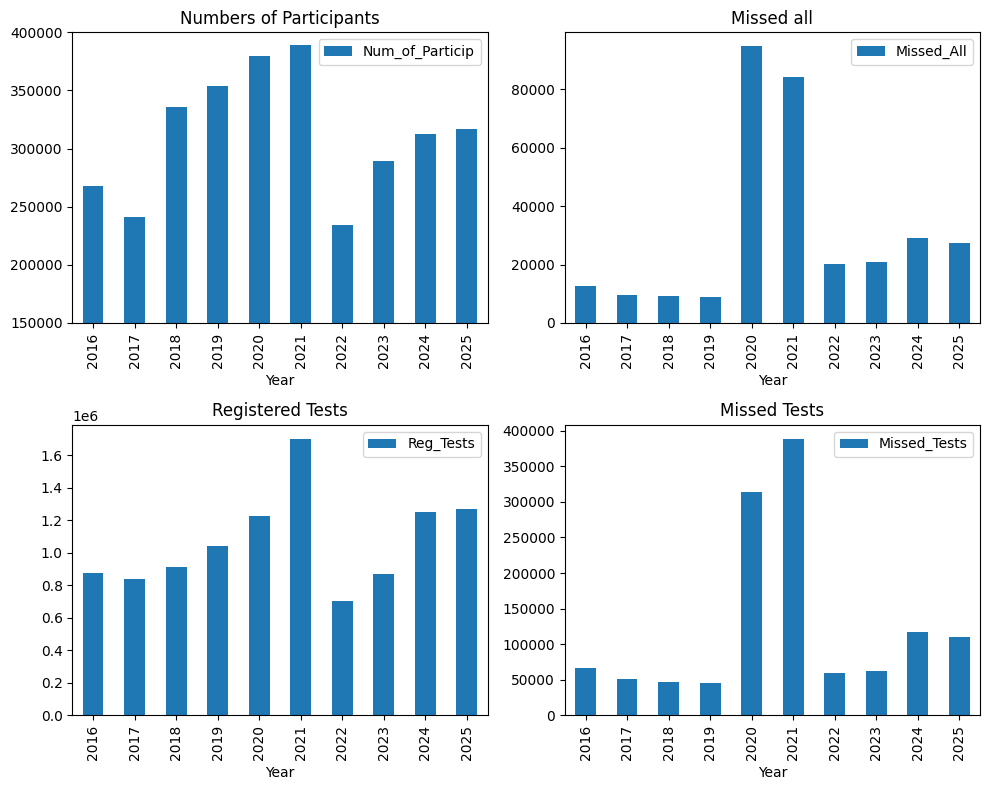

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

noshow_by_year.plot(kind='bar', 
                    x='Year', y='Num_of_Particip', 
                    ylim=(150000, 400000),
                    ax=axes[0, 0], title='Numbers of Participants')
noshow_by_year.plot(kind='bar', x='Year', y='Missed_All', ax=axes[0, 1], title='Missed all')
noshow_by_year.plot(kind='bar', x='Year', y='Reg_Tests', ax=axes[1, 0], title='Registered Tests')
noshow_by_year.plot(kind='bar', x='Year', y='Missed_Tests', ax=axes[1, 1], title='Missed Tests')

plt.tight_layout()


	•	Укр:
(Num_of_Particip, Missed_all, Missed_All_Perc) – кількість учасників, які не з’явилися на жоден із зареєстрованих тестів.
(Reg_Tests, Missed_Tests, Missed_Tests_Perc) – кількість тестів, на які були зареєстровані учасники, та які були пропущені.

Особливо помітно, як у 2020 та 2021 роках цей показник значно зріс. Це пов’язано з пандемією COVID-19 та організаційним хаосом. Тестування кілька разів переносили, змінювали правила, а регіони закривали на локдауни.

	•	Англ:
(Num_of_Particip, Missed_all, Missed_All_Perc) – number of participants who did not attend any of the registered tests.
(Reg_Tests, Missed_Tests, Missed_Tests_Perc) – number of tests participants were registered for but missed.

It is especially noticeable that in 2020 and 2021 this indicator increased significantly. This is due to the COVID-19 pandemic and organizational chaos. Testing was postponed several times, rules were changed, and regions were put under lockdowns.

	•	Рус:
(Num_of_Particip, Missed_all, Missed_All_Perc) – количество участников, которые не явились ни на один из зарегистрированных тестов.
(Reg_Tests, Missed_Tests, Missed_Tests_Perc) – количество тестов, на которые были зарегистрированы участники, но которые были пропущены.

Особенно заметно, что в 2020 и 2021 годах этот показатель значительно вырос. Это связано с пандемией COVID-19 и организационным хаосом. Тестирование несколько раз переносили, меняли правила, а регионы закрывали на локдауны.

### Середній / медіанний бал за роками | Average / median score by year | Средний / медианный балл по годам

In [30]:
balls = df[[pref + 'Ball' for pref in prefs] + ['Year']]

In [31]:
#cреднее по участнику вкл тех кто не сдал(99)
balls['avg_by_person'] = balls[[pref + 'Ball' for pref in prefs]].mean(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_48461/1740008123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['avg_by_person'] = balls[[pref + 'Ball' for pref in prefs]].mean(axis=1)


In [32]:
balls['avg_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, np.nan).mean(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_48461/2217575131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['avg_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, np.nan).mean(axis=1)


In [33]:
#cредний балл по годам по всем предметам
mean_ball_by_year = balls.groupby('Year')['avg_by_person'].mean().reset_index()

In [34]:
passed_mean_ball_by_year = balls.groupby('Year')['avg_by_passed_person'].mean().round(1).reset_index()

In [35]:
mean_ball_by_year['avg_by_person'] = mean_ball_by_year['avg_by_person'].round(1)

In [36]:
mean_ball = mean_ball_by_year.merge(passed_mean_ball_by_year)

In [37]:
#медианный балл участника 
balls['median_by_person'] = balls[[pref + 'Ball' for pref in prefs]].median(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_48461/1946889165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['median_by_person'] = balls[[pref + 'Ball' for pref in prefs]].median(axis=1)


In [38]:
balls['median_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, pd.NA).median(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_48461/1881592709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['median_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, pd.NA).median(axis=1)


In [39]:
passed_median_ball_by_year = balls.groupby('Year')['median_by_passed_person'].median().reset_index()

In [40]:
median_ball_by_year = balls.groupby('Year')['median_by_person'].median().reset_index()

In [41]:
median_ball = median_ball_by_year.merge(passed_median_ball_by_year)

In [42]:
by_year = median_ball.merge(mean_ball, on='Year')

In [43]:
by_year

,Year,median_by_person,median_by_passed_person,avg_by_person,avg_by_passed_person
0,2016,130.0,134.0,133.7,137.2
1,2017,132.5,135.0,135.3,138.2
2,2018,126.0,132.0,130.6,135.6
3,2019,127.0,131.5,131.0,135.4
4,2020,133.0,135.0,135.9,138.2
5,2021,133.0,136.0,135.7,138.7
6,2022,147.0,147.0,151.3,151.4
7,2023,143.0,143.0,142.6,143.1
8,2024,141.0,141.5,140.5,141.8
9,2025,140.5,141.0,139.9,141.1


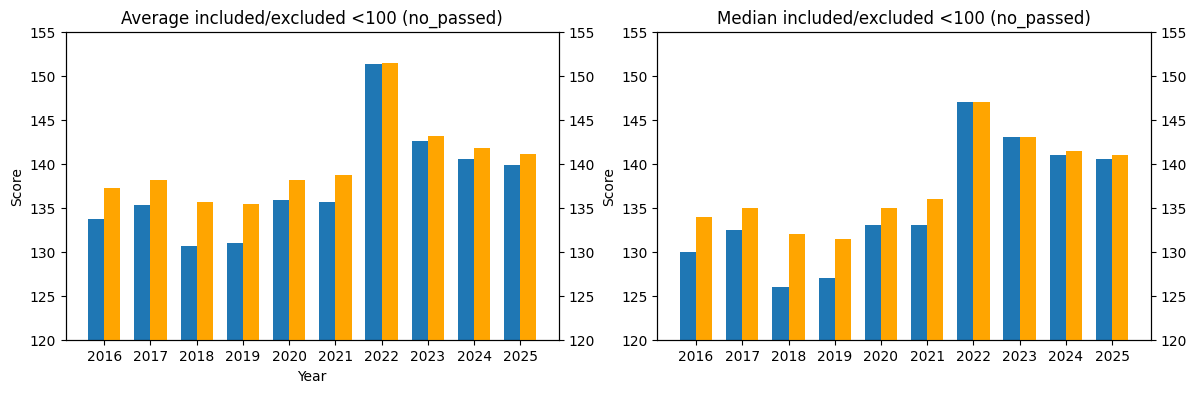

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
x = np.arange(len(by_year['Year']))
width = 0.35 

ax[0].bar(x - width/2, by_year['avg_by_person'], width=width)
ax[0].set_ylim(120, 155)
ax1 = ax[0].twinx()
ax1.bar(x + width/2, by_year['avg_by_passed_person'], width=width, color='orange')
ax1.set_ylim(120, 155)

ax[1].bar(x - width/2, by_year['median_by_person'], width=width)
ax[1].set_ylim(120, 155)
ax2 = ax[1].twinx()
ax2.bar(x + width/2, by_year['median_by_passed_person'], width=width, color='orange')
ax2.set_ylim(120, 155)

ax[0].set_xticks(x)
ax[0].set_xticklabels(by_year['Year'])
ax[1].set_xticks(x)
ax[1].set_xticklabels(by_year['Year'])

ax[0].set_ylabel('Score')
ax[1].set_ylabel('Score')
ax[0].set_xlabel('Year')
ax[0].set_xlabel('Year')

ax[0].set_title('Average included/excluded <100 (no_passed)')
ax[1].set_title('Median included/excluded <100 (no_passed)')

mean_median_by_year_plot = fig

	•	Укр:
У 2022 році спостерігається різке зростання показників, ймовірно через спрощену форму НМТ у зв’язку з війною. Також видно, що середній бал і медіана з урахуванням учасників, які не склали тест (ball=99), практично не відрізняються від середнього і медіани без урахування тих, що не склали. Це свідчить про те, що майже всі учасники у 2022 році успішно склали тести.

	•	Англ:
In 2022, there is a sharp increase in the indicators, likely due to the simplified form of the NMT because of the war. It is also noticeable that the average score and median including participants who did not pass the test (ball=99) are almost the same as the average and median excluding those who did not pass. This indicates that almost all participants in 2022 successfully passed the tests.

	•	Рус:
В 2022 году наблюдается резкий рост показателей, вероятно, из-за упрощённой формы НМТ в связи с войной. Также видно, что средний балл и медиана с учётом участников, которые не сдали тест (ball=99), практически не отличаются от среднего и медианы без учёта тех, кто не сдал. Это свидетельствует о том, что почти все участники в 2022 году успешно сдали тесты.

### Стандартне відхилення | Standard deviation | Стандартное отклонение

In [45]:
by_year = by_year.merge(balls.groupby('Year')['avg_by_person'].std().round(2).reset_index(), on='Year')

In [46]:
by_year = by_year.rename(columns={'avg_by_person_y': 'Std'})

In [47]:
by_year

,Year,median_by_person,median_by_passed_person,avg_by_person_x,avg_by_passed_person,Std
0,2016,130.0,134.0,133.7,137.2,25.09
1,2017,132.5,135.0,135.3,138.2,25.24
2,2018,126.0,132.0,130.6,135.6,25.30
3,2019,127.0,131.5,131.0,135.4,25.24
4,2020,133.0,135.0,135.9,138.2,25.32
5,2021,133.0,136.0,135.7,138.7,25.66
6,2022,147.0,147.0,151.3,151.4,15.80
7,2023,143.0,143.0,142.6,143.1,15.83
8,2024,141.0,141.5,140.5,141.8,15.07
9,2025,140.5,141.0,139.9,141.1,14.61


In [48]:
balls = balls.rename(columns={'avg_by_person':'avg_all',
                      'median_by_person': 'median_all',
                      'avg_by_passed_person': 'avg_by_passed',
                      'median_by_passed_person': 'median_by_passed'})

In [49]:
new_columns = ['Year', 'median_all', 'median_by_passed', 'avg_all', 'avg_by_passed']
by_year = by_year.rename(columns=dict(zip(list(by_year.columns), new_columns)))
by_year = by_year.merge(balls.groupby('Year')[['avg_all', 'avg_by_passed', 'median_all', 'median_by_passed']] \
    .std().round(2).reset_index(), on='Year', suffixes=('', '_std'))

In [50]:
by_year = by_year[['Year', 'avg_all', 'avg_all_std', 'avg_by_passed', 'avg_by_passed_std', 
                 'median_all', 'median_all_std', 'median_by_passed', 'median_by_passed_std']]

In [51]:
by_year

,Year,avg_all,avg_all_std,avg_by_passed,avg_by_passed_std,median_all,median_all_std,median_by_passed,median_by_passed_std
0,2016,133.7,25.09,137.2,23.46,130.0,26.35,134.0,24.55
1,2017,135.3,25.24,138.2,23.69,132.5,26.75,135.0,24.87
2,2018,130.6,25.30,135.6,23.47,126.0,26.45,132.0,24.45
3,2019,131.0,25.24,135.4,23.46,127.0,26.29,131.5,24.35
4,2020,135.9,25.32,138.2,24.00,133.0,26.62,135.0,25.06
5,2021,135.7,25.66,138.7,23.99,133.0,27.36,136.0,25.41
6,2022,151.3,15.80,151.4,15.74,147.0,16.35,147.0,16.27
7,2023,142.6,15.83,143.1,15.38,143.0,15.62,143.0,15.29
8,2024,140.5,15.07,141.8,14.18,141.0,14.60,141.5,13.85
9,2025,139.9,14.61,141.1,13.75,140.5,14.16,141.0,13.44


### % високобалів / низькобалів
Високобалі = >180
Низькобалі = 100–120
Не набрали прохідний бал = 99

% high scorers / low scorers
High scorers = >180
Low scorers = 100–120
Did not reach passing score = 99

% высокобалльников / низкобалльников
Высокобалльники = >180
Низкобалльники = 100–120
Не набрали проходной балл = 99

In [53]:
mask_highscore = (balls['avg_all'] >= 180) | (balls['median_all'] >= 180)
mask_lowscore = (balls['avg_all'].between(100, 120)) | (balls['median_all'].between(100, 120))

In [54]:
'''
фильтрую участников которые получили cредний или медианный балл >180.
Если использовать только среднее, можно пропустить участника, который очень хорошо сдал один предмет, 
а в других немного ниже, — среднее может «разбавить» высокий результат.
Если использовать только медиану, можно пропустить участника с сильными колебаниями: 
например, 200, 180, 100 → медиана 180, среднее ~160.
Комбинированный подход позволяет включить тех, кто либо стабильно высокий (высокая медиана), 
либо у кого есть хотя бы один очень высокий результат (среднее поднимется).
'''
high_ball_persons = balls[mask_highscore]

In [56]:
low_ball_persons = balls[mask_lowscore]

In [58]:
temp = df['Year'].value_counts().reset_index() \
        .merge(high_ball_persons['Year'].value_counts().reset_index(),
         on='Year',
         suffixes=('_total', '_high_ball'))

In [59]:
temp = temp.merge(low_ball_persons['Year'].value_counts().reset_index(), on='Year').rename(columns={'count':'count_low_balls'})

In [60]:
#использую медианну, чтобы найти участников которые провалили тесты так как среднее разбавит результат
# если например участник завалил 3 теста, но сдал только 1. 
temp = temp.merge(balls[(balls['median_all'] == 99)]['Year'] \
    .value_counts().reset_index(), on='Year') \
    .rename(columns={'count':'count_failed'})

In [61]:
temp['%_high_ball'] = (temp['count_high_ball'] / temp['count_total'] * 100).round(1)

In [62]:
temp['%_low_ball'] = (temp['count_low_balls'] / temp['count_total'] * 100).round(1)

In [63]:
temp['%_failed'] = (temp['count_failed'] / temp['count_total'] * 100).round(1)

In [64]:
high_low_failed_by_year = temp[['Year', 'count_total', 
      'count_high_ball', '%_high_ball',
      'count_low_balls', '%_low_ball',
      'count_failed', '%_failed'
      ]].sort_values('Year')

In [65]:
#общая таблица высокобальных/низкобальных, и проваливших тесты.
high_low_failed_by_year

,Year,count_total,count_high_ball,%_high_ball,count_low_balls,%_low_ball,count_failed,%_failed
7,2016,268003,16060,6.0,84714,31.6,16573,6.2
8,2017,240889,16880,7.0,75575,31.4,18311,7.6
3,2018,335687,17911,5.3,106670,31.8,45147,13.4
2,2019,353813,19194,5.4,116826,33.0,36487,10.3
1,2020,379299,21794,5.7,92411,24.4,17015,4.5
0,2021,389323,25465,6.5,98829,25.4,23884,6.1
9,2022,234104,20747,8.9,517,0.2,232,0.1
6,2023,288935,9546,3.3,14524,5.0,408,0.1
5,2024,312508,5850,1.9,17690,5.7,52,0.0
4,2025,317091,4803,1.5,18654,5.9,53,0.0


Text(0.5, 1.0, 'Percentage of failed by year')

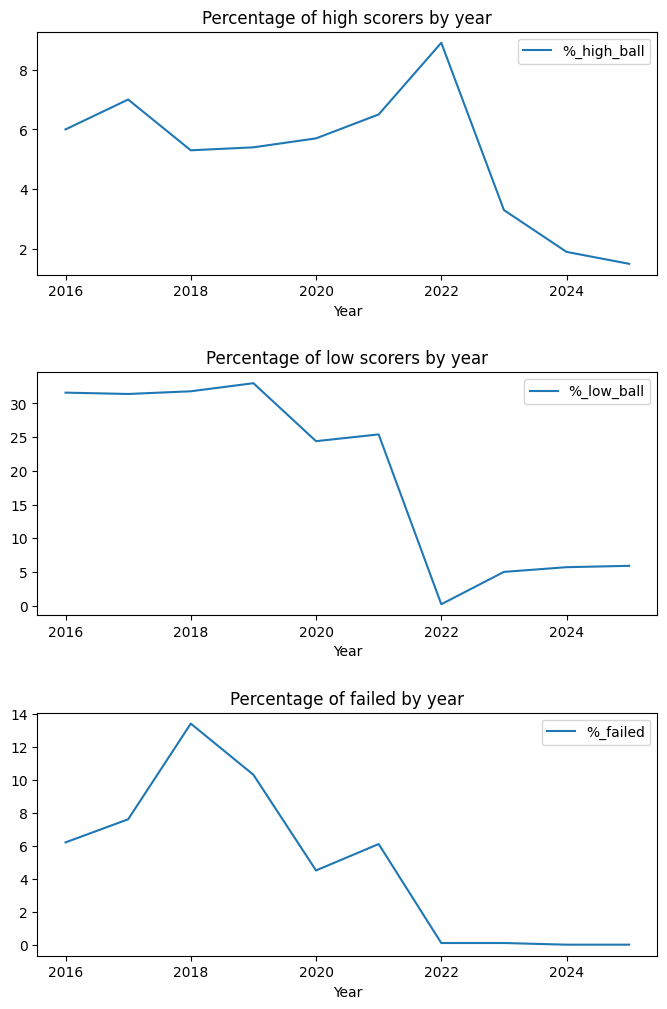

In [78]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.4)

high_low_failed_by_year.plot(x='Year', y='%_high_ball', ax=axes[0])
axes[0].set_title('Percentage of high scorers by year')

high_low_failed_by_year.plot(x='Year', y='%_low_ball', ax=axes[1])
axes[1].set_title('Percentage of low scorers by year')

high_low_failed_by_year.plot(x='Year', y='%_failed', ax=axes[2])
axes[2].set_title('Percentage of failed by year')

Укр:
Чітко простежується зниження частки учасників з високими балами, низькими балами та тих, хто повністю не склав тест, починаючи з 2022 року. Це пов’язано із запровадженням нової, спрощеної системи оцінювання. Подальший аналіз із використанням гістограм розподілу дозволить наочно підтвердити ці відмінності.

Eng:
A clear decline in the share of high scorers, low scorers, and participants who completely failed the test is observed starting from 2022. This trend is associated with the introduction of a new simplified scoring system. Further analysis using distribution histograms will visually confirm these differences.

Рус:
Чётко наблюдается снижение доли участников с высокими баллами, низкими баллами, а также полностью не сдавших тест, начиная с 2022 года. Это связано с внедрением новой упрощённой системы оценивания. Дальнейший анализ с использованием гистограмм распределения наглядно покажет эти различия.